In [80]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import cycle

import sys
sys.path.append("/home/eko/lib/icd_helpers")
from show_confusion_matrix import *

from sklearn.preprocessing import binarize
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [2]:
base_results_path="/home/eko/projects/icahnc_cth/cth_cnn/results"
results_file="M_volresnet_Yn2_Bn4_A_False_GPU1_test-y_pred.csv"
n_classes=2


df_dtmv=pd.read_excel("/home/eko/projects/icahnc_cth/cth_cnn/data/labels/data_test_man_val_7.xlsx")
df_results=pd.read_csv(os.path.join(base_results_path,results_file),header=None)
df_results=df_results.rename(columns={0:"predpos",1:"predneg"})
df_results=df_results[0:149]
print(df_results.shape)
print(df_results.columns)
print(df_dtmv.shape)
print(df_dtmv.columns)

(149, 2)
Index(['predpos', 'predneg'], dtype='object')
(149, 37)
Index(['Unnamed: 0', 'final_shape', 'img_path', 'original_dims',
       'accession_id', 'patient_age', 'patient_id', 'patient_sex',
       'post_cube_dims', 'post_rescale_dims', 'sopinstanceuid', 'age_x', 'gen',
       'is_stat_x', 'loc', 'pred_crit_at_4', 'pred_crit_at_4_2',
       'pred_crit_at_4_3', 'pred_crit_at_10', 'pred_crit_at_8',
       'true_nlp_crit_at_4', 'true_nlp_crit_at_8', 'true_nlp_crit_at_10',
       'true_ATTG', 'true_JAVIN', 'true_eko', 'technical_challenge_javin',
       'technical_challenge_eko', 'uncertain', 'majority_vote', 'comments',
       'age_y', 'filenames', 'gender', 'is_stat_y', 'labels', 'location'],
      dtype='object')


In [3]:
y_score = df_results["predneg"].as_matrix()
y_test = df_dtmv["true_ATTG"].as_matrix()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# combo'd

In [4]:
base_results_path="/home/eko/projects/icahnc_cth/cth_cnn/results/cth_folds/FOLDS.xlsx"
n_classes=2


df_dtmv=pd.read_excel("/home/eko/projects/icahnc_cth/cth_cnn/data/labels/data_test_man_val_7.xlsx")
df_results=pd.read_excel(base_results_path)
df_results=df_results[0:149]
print(df_results.shape)
print(df_results.columns)
print(df_dtmv.shape)
print(df_dtmv.columns)

(149, 5)
Index(['fold1', 'fold2', 'fold3', 'fold4', 'fold5'], dtype='object')
(149, 37)
Index(['Unnamed: 0', 'final_shape', 'img_path', 'original_dims',
       'accession_id', 'patient_age', 'patient_id', 'patient_sex',
       'post_cube_dims', 'post_rescale_dims', 'sopinstanceuid', 'age_x', 'gen',
       'is_stat_x', 'loc', 'pred_crit_at_4', 'pred_crit_at_4_2',
       'pred_crit_at_4_3', 'pred_crit_at_10', 'pred_crit_at_8',
       'true_nlp_crit_at_4', 'true_nlp_crit_at_8', 'true_nlp_crit_at_10',
       'true_ATTG', 'true_JAVIN', 'true_eko', 'technical_challenge_javin',
       'technical_challenge_eko', 'uncertain', 'majority_vote', 'comments',
       'age_y', 'filenames', 'gender', 'is_stat_y', 'labels', 'location'],
      dtype='object')


In [5]:
df_results.head()

fold1     fold2     fold3     fold4     fold5
0  0.642917  0.642917  0.952909  0.957273  0.708646
1  0.651095  0.651095  0.238622  0.194330  0.524929
2  0.557934  0.557934  0.877790  0.963277  0.768247
3  0.611377  0.611377  0.922314  0.990347  0.727451
4  0.620745  0.620745  0.917894  0.778481  0.637461

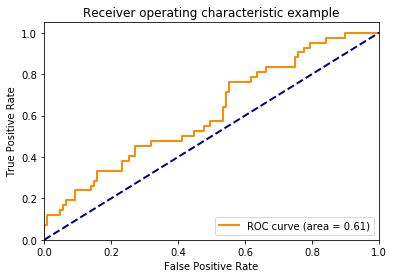

In [6]:


y_score = 1 - df_results["fold1"].as_matrix()
y_test = df_dtmv["true_ATTG"].as_matrix()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

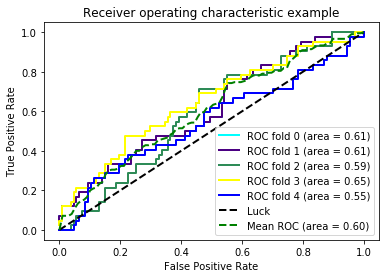

In [7]:
# Run classifier with cross-validation and plot ROC curves

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

splits = [
  (df_results["fold1"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold2"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold3"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold4"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold5"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
]
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(splits, colors):
    probas_ = train
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(test,1 - probas_)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= len(splits)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Ensemble

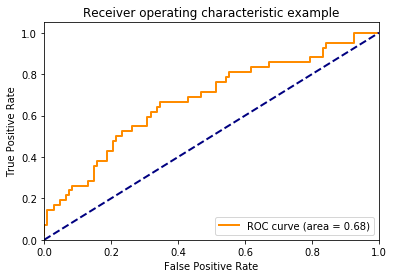

/opt/software/anaconda3-4.3.0/envs/tensorflow-1.2.0-keras-2.0.5/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


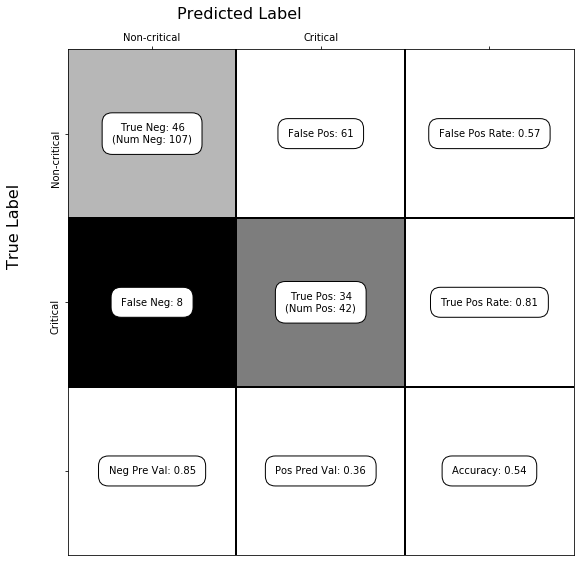

In [52]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

#clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
# clf = AdaBoostClassifier(n_estimators=100)

X = df_results[["fold1", "fold2", "fold3", "fold4", "fold5"]].as_matrix()
y = df_dtmv["true_ATTG"].as_matrix()

y_score = 1-X.mean(axis=1)
y_test = df_dtmv["true_ATTG"].as_matrix()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresh = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test,binarize(y_score, threshold=0.3)[0])
show_confusion_matrix(cm,["Non-critical","Critical"])

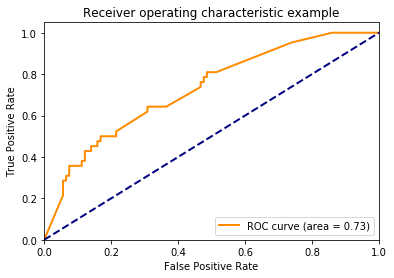

/opt/software/anaconda3-4.3.0/envs/tensorflow-1.2.0-keras-2.0.5/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


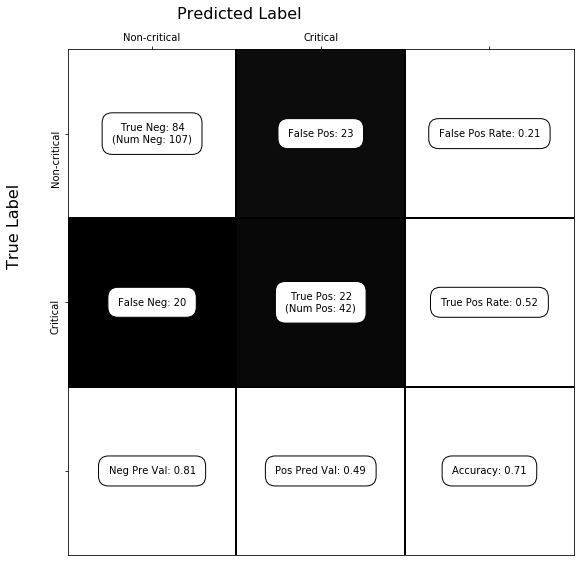

In [71]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet

X = df_results[["fold1", "fold2", "fold3", "fold4", "fold5"]].as_matrix()
y = df_dtmv["true_ATTG"].as_matrix()

clf = ElasticNet(alpha=0.1, l1_ratio=0.33)
#clf = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
# clf = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, bootstrap=True, random_state=0,
#                            class_weight={1:0.0001})
#clf = AdaBoostClassifier(n_estimators=100)

scores = cross_val_score(clf, X, y, cv=10)
ensemble_predicted = cross_val_predict(clf, X, y, cv=10)

y_score = 1-ensemble_predicted
y_test = df_dtmv["true_ATTG"].as_matrix()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test,binarize(y_score, threshold=0.72)[0])
show_confusion_matrix(cm,["Non-critical","Critical"])


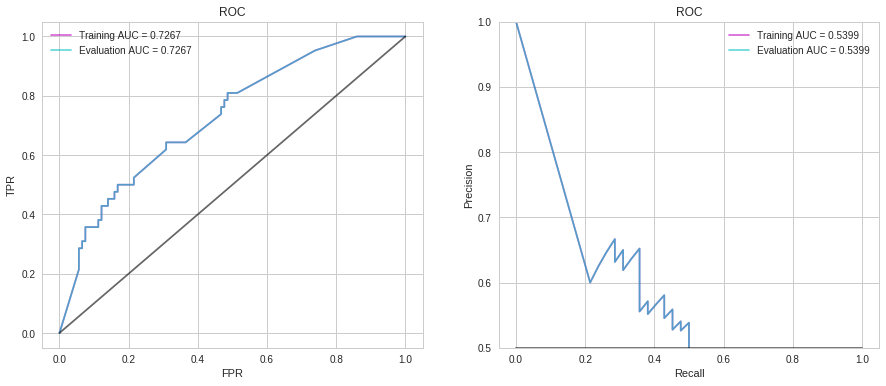

In [88]:
# y_train=[]
# y_val=[]
# with open('./datasets/stl10/images/train.lst','r') as csvfile:
#   spamreader = csv.reader(csvfile, delimiter='\t')
#   for row in spamreader:
#     y_train.append(int(row[1]))
# with open('./datasets/stl10/images/val.lst','r') as csvfile:
#   spamreader = csv.reader(csvfile, delimiter='\t')
#   for row in spamreader:
#     y_val.append(int(row[1]))
#y_train=np.array(y_train)
#y_train_pred = model.predict( train )[:,1]
#y_val=np.array(y_val)
#y_eval_pred = model.predict( val )[:,1]

y_train_pred = 1-ensemble_predicted
y_train = df_dtmv["true_ATTG"].as_matrix()
y_eval_pred = 1-ensemble_predicted
y_val = df_dtmv["true_ATTG"].as_matrix()

t_fpr, t_tpr, _ = roc_curve( y_train, y_train_pred )
t_precision, t_recall, _ = precision_recall_curve( y_train, y_train_pred )
e_fpr, e_tpr, _ = roc_curve( y_val, y_eval_pred )
e_precision, e_recall, _ = precision_recall_curve( y_val, y_eval_pred )

sns.set_style('whitegrid')
plt.figure( figsize=(15, 6) )
train_auc = np.around( auc(t_fpr, t_tpr), 4 )
eval_auc = np.around( auc(e_fpr, e_tpr), 4 )
plt.subplot(121)
plt.title( "ROC" )
plt.xlabel( "FPR" )
plt.ylabel( "TPR" )
plt.plot( t_fpr, t_tpr, alpha=0.6, c='m', label="Training AUC = {}".format( train_auc ) )
plt.plot( e_fpr, e_tpr, alpha=0.6, c='c', label="Evaluation AUC = {}".format( eval_auc ) )
plt.plot( [0,1], [0, 1], c='k', alpha=0.6 )
plt.legend( loc=2 )
train_auc = np.around( average_precision_score( y_train, y_train_pred ), 4 )
eval_auc = np.around( average_precision_score( y_val, y_eval_pred ), 4 )
plt.subplot(122)
plt.title( "ROC" )
plt.xlabel( "Recall" )
plt.ylabel( "Precision" )
plt.plot( t_recall, t_precision, alpha=0.6, c='m', label="Training AUC = {}".format( train_auc ) )
plt.plot( e_recall, e_precision, alpha=0.6, c='c', label="Evaluation AUC = {}".format( eval_auc ) )
plt.plot( [0,1], [0.5, 0.5], c='k', alpha=0.6 )
plt.ylim(0.5, 1.0)
plt.legend()
plt.savefig("/home/eko/projects/icahnc_cth/cth_cnn/results/roc.png", dpi=300)
plt.show()


## ENSEMBLE PLOT

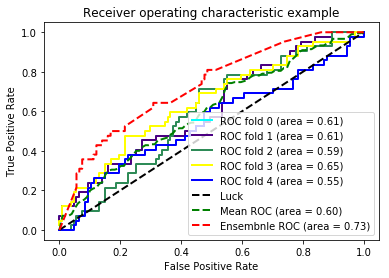

In [11]:

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

splits = [
  (df_results["fold1"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold2"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold3"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold4"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
  (df_results["fold5"].as_matrix(),df_dtmv["true_ATTG"].as_matrix()),
]
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2


i = 0
for (train, test), color in zip(splits, colors):
    probas_ = train
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(test,1 - probas_)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= len(splits)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

e_fpr, e_tpr, e_thresholds = roc_curve(test,1 - ensemble_predicted)
e_auc = auc(e_fpr, e_tpr)
plt.plot(e_fpr, e_tpr, color='r', linestyle='--',
         label='Ensembnle ROC (area = %0.2f)' % e_auc, lw=lw)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/home/eko/lib/icd_helpers/show_confusion_matrix.py:101: RuntimeWarning: invalid value encountered in true_divide
  'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),


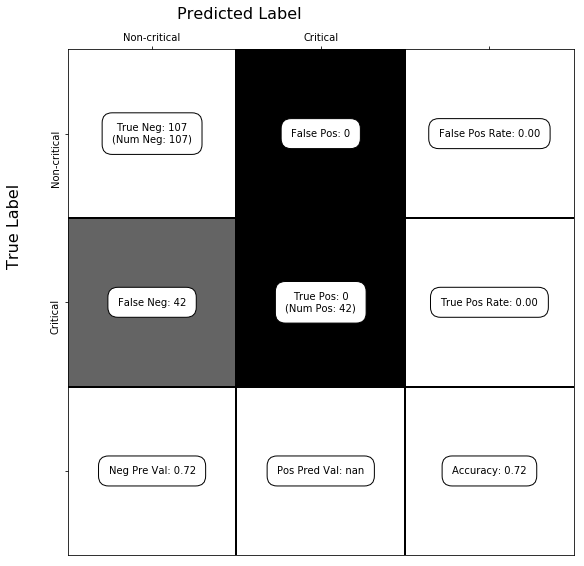

# Nice Figures

/opt/software/anaconda3-4.3.0/envs/tensorflow-1.2.0-keras-2.0.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


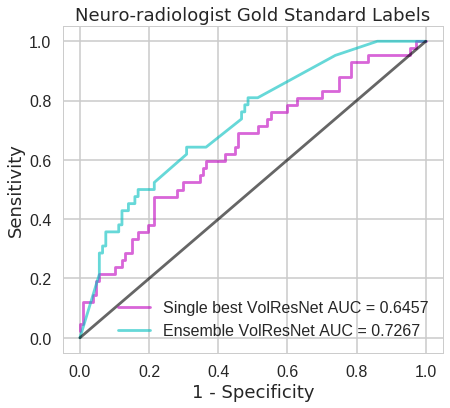

In [135]:
TARGET = "true_ATTG"

X = df_results[["fold4"]].as_matrix()
best_img_predicted = X

X = df_results[["fold1", "fold2", "fold3", "fold4", "fold5"]].as_matrix()
y = df_dtmv[TARGET].as_matrix()
clf_e = ElasticNet(alpha=0.1, l1_ratio=0.33)
ensemble_predicted = cross_val_predict(clf_e, X, y, cv=10)

y_train_pred = 1-best_img_predicted
y_train = df_dtmv[TARGET].as_matrix()
y_eval_pred = 1-ensemble_predicted
y_val = df_dtmv[TARGET].as_matrix()

t_fpr, t_tpr, _ = roc_curve( y_train, y_train_pred )
t_precision, t_recall, _ = precision_recall_curve( y_train, y_train_pred )
e_fpr, e_tpr, _ = roc_curve( y_val, y_eval_pred )
e_precision, e_recall, _ = precision_recall_curve( y_val, y_eval_pred )

sns.set_style('whitegrid')
sns.set_context("poster")
plt.figure( figsize=(15, 6) )
train_auc = np.around( auc(t_fpr, t_tpr), 4 )
eval_auc = np.around( auc(e_fpr, e_tpr), 4 )
plt.subplot(121)
plt.title( "Neuro-radiologist Gold Standard Labels", fontname="Arial", fontsize=18 )
plt.xlabel( "1 - Specificity", fontname="Arial", fontsize=18 )
plt.ylabel( "Sensitivity", fontname="Arial", fontsize=18 )

plt.plot( t_fpr, t_tpr, alpha=0.6, c='m', label="Single best VolResNet AUC = {}".format( train_auc ) )
plt.plot( e_fpr, e_tpr, alpha=0.6, c='c', label="Ensemble VolResNet AUC = {}".format( eval_auc ) )
plt.plot( [0,1], [0, 1], c='k', alpha=0.6 )
plt.legend( loc=4 )
  
    
# train_auc = np.around( average_precision_score( y_train, y_train_pred ), 4 )
# eval_auc = np.around( average_precision_score( y_val, y_eval_pred ), 4 )

plt.savefig("/home/eko/projects/icahnc_cth/cth_cnn/results/roc_gold_standard.png", dpi=300)
plt.show()


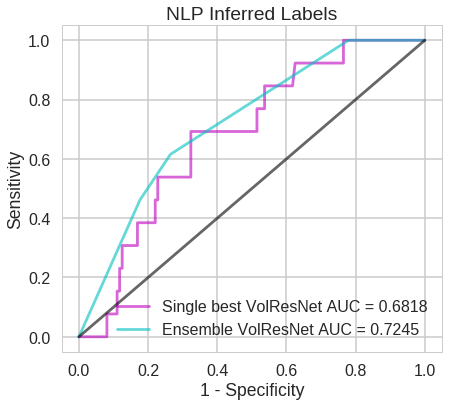

In [136]:
TARGET = "true_nlp_crit_at_10"


X = df_results[["fold5"]].as_matrix()
best_img_predicted = X

X = df_results[["fold1", "fold2", "fold3", "fold4", "fold5"]].as_matrix()
y = df_dtmv[TARGET].as_matrix()
clf_e = ElasticNet(alpha=0.1, l1_ratio=0.33)
ensemble_predicted = cross_val_predict(clf_e, X, y, cv=10)

y_train_pred = 1-best_img_predicted
y_train = df_dtmv[TARGET].as_matrix()
y_eval_pred = 1-ensemble_predicted
y_val = df_dtmv[TARGET].as_matrix()

t_fpr, t_tpr, _ = roc_curve( y_train, y_train_pred )
t_precision, t_recall, _ = precision_recall_curve( y_train, y_train_pred )
e_fpr, e_tpr, _ = roc_curve( y_val, y_eval_pred )
e_precision, e_recall, _ = precision_recall_curve( y_val, y_eval_pred )

sns.set_style('whitegrid')
sns.set_context("poster")
plt.figure( figsize=(15, 6) )
train_auc = np.around( auc(t_fpr, t_tpr), 4 )
eval_auc = np.around( auc(e_fpr, e_tpr), 4 )
plt.subplot(121)
plt.title( "NLP Inferred Labels" )
plt.xlabel( "1 - Specificity" )
plt.ylabel( "Sensitivity" )
plt.plot( t_fpr, t_tpr, alpha=0.6, c='m', label="Single best VolResNet AUC = {}".format( train_auc ) )
plt.plot( e_fpr, e_tpr, alpha=0.6, c='c', label="Ensemble VolResNet AUC = {}".format( eval_auc ) )
plt.plot( [0,1], [0, 1], c='k', alpha=0.6 )
plt.legend( loc=4 )
train_auc = np.around( average_precision_score( y_train, y_train_pred ), 4 )
eval_auc = np.around( average_precision_score( y_val, y_eval_pred ), 4 )

plt.savefig("/home/eko/projects/icahnc_cth/cth_cnn/results/roc_silver_standard.png", dpi=300)
plt.show()

